In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import r2_score, accuracy_score, recall_score, confusion_matrix, precision_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

## Load & preprocess the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/archive"

In [ ]:
# Lists all files and folders inside the dataset_path directory and prints them.
import os
print(os.listdir(dataset_path))

['translate.py', 'raw-img']


In [ ]:
image_dir = os.path.join(dataset_path, "raw-img")
print(os.listdir(image_dir)[:10])

['farfalla', 'mucca', 'cane', 'cavallo', 'ragno', 'gallina', 'pecora', 'gatto', 'scoiattolo', 'elefante']


In [ ]:
dataset_path = os.path.join(dataset_path, "raw-img")

# Loads images from dataset_path as a dataset
train_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),# Resizes images to 224×224 pixels.
    batch_size=32, # Groups images into batches of 32.
    shuffle=True
)

class_names = train_dataset.class_names
print("Class Names:", class_names)

Found 26179 files belonging to 10 classes.
Class Names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


## Split the dataset

In [ ]:
train_size = 0.8
train_batches = int(len(train_dataset) * train_size)# Calculates the number of batches for training.

train_data = train_dataset.take(train_batches) # Takes the first 80% of batches for training.
val_data = train_dataset.skip(train_batches) # keeps the remaining 20% for validation.

## Visualize some images and their labels

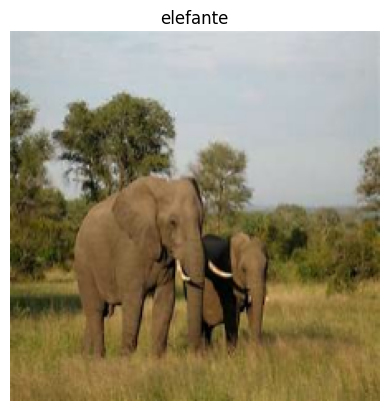

In [ ]:
for images, labels in train_dataset.take(1): # Takes one batch of images and labels from train_dataset.
    plt.imshow(images[0].numpy().astype("uint8")) # Selects the first image from the batch.
    plt.title(class_names[labels[0]]) # Gets the class label of the first image and sets it as the title of the image.
    plt.axis("off")
    plt.show()

## Normalizing & Resizing the dataset

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Applies the normalization layer to all images but Keeps labels (y) unchanged.
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
val_data = val_data.map(lambda x, y: (normalization_layer(x), y))

 ## Build CNN model

In [ ]:
# creates an image data generator (datagen) that applies data augmentation to images:
datagen = ImageDataGenerator(
    rescale=1./255,# Normalizes pixel values from [0, 255] to [0, 1].
    rotation_range=20, #Randomly rotates images up to 20 degrees.
    width_shift_range=0.2, # Shifts images horizontally by up to 20%.
    height_shift_range=0.2, # Shifts images vertically by up to 20%.
    horizontal_flip=True, # Randomly flips images horizontally (left-right)
    validation_split=0.2
) # This helps increase dataset diversity and prevent overfitting, making the model more generalizable to unseen data.

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense

# defines a Convolutional Neural Network for image classification using TensorFlow/Keras
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),  # helps stabilize and speed up training.
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),  # helps stabilize and speed up training.
    layers.MaxPooling2D((2, 2)),

    Flatten(), # Flattens the 2D feature maps into a 1D vector

    Dense(512, activation='relu'),
    BatchNormalization(),  # helps stabilize and speed up training.
    Dropout(0.5), # Drops 50% of neurons randomly to prevent overfitting

    Dense(256, activation='relu'),
    BatchNormalization(),  # helps stabilize and speed up training.
    Dropout(0.5), # Drops 50% of neurons randomly to prevent overfitting

    Dense(10, activation='softmax')
])

# Defines the Adam optimizer with a smaller learning rate (0.0005) for more stable training.
optimizer = Adam(learning_rate=0.0005)

#  Compiling the Model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Prints a detailed summary
model.summary()

# Sets up early stopping to prevent overfitting during training:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# If the model's validation loss does not improve for 5 consecutive epochs, training stops early.
# After stopping, the model reverts to the best weights (from the epoch with the lowest validation loss).

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,217,930 (100.01 MB)

 Trainable params: 26,215,434 (100.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Sets up learning rate reduction when training slows down:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [ ]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,  # The model evaluates its performance on validation data after each epoch to check for overfitting.
    epochs=30,
    batch_size=128, # process 128 images at a time in each batch during training.
    callbacks=[early_stopping, reduce_lr] # stops training and reduces the learning rate if the validation loss stops improving for 3 epochs.
)

Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 178s 252ms/step - accuracy: 0.2881 - loss: 2.4996 - val_accuracy: 0.4976 - val_loss: 1.5316 - learning_rate: 5.0000e-04
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 218s 333ms/step - accuracy: 0.4888 - loss: 1.5470 - val_accuracy: 0.6101 - val_loss: 1.1511 - learning_rate: 5.0000e-04
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 164s 251ms/step - accuracy: 0.5793 - loss: 1.2603 - val_accuracy: 0.6394 - val_loss: 1.0639 - learning_rate: 5.0000e-04
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 161s 246ms/step - accuracy: 0.6564 - loss: 1.0070 - val_accuracy: 0.6003 - val_loss: 1.2062 - learning_rate: 5.0000e-04
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 206s 252ms/step - accuracy: 0.7283 - loss: 0.7999 - val_accuracy: 0.6940 - val_loss: 0.9342 - learning_rate: 5.0000e-04
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 163s 249ms/step - accuracy: 0.7695 - loss: 0.6761 - val_accuracy: 0.7011 - val_loss: 0.9015 - learning_rate: 5.0000e-04
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluate the model

In [ ]:
# evaluates the model's performance on the validation data:
loss, accuracy = model.evaluate(val_data)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 92s 116ms/step - accuracy: 0.7711 - loss: 0.7501
Validation Loss: 0.8225563168525696, Validation Accuracy: 0.7493772506713867


## Report metrics: accuracy, precision, recall, and F1-score

In [ ]:
import numpy as np

# These lists will store actual and predicted labels.
true_labels = []
predicted_labels = []

for images, labels in val_data:
    preds = model.predict(images) # The model predicts class probabilities for the batch.
    predicted_labels.extend(np.argmax(preds, axis=1)) # Convert Predictions to Class Labels
    true_labels.extend(labels.numpy()) # Converts labels to a NumPy array and stores them in true_labels.

# Converts lists into arrays for further analysis:
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.7494
Precision: 0.7562
Recall: 0.7494
F1-score: 0.7444


## Visualize


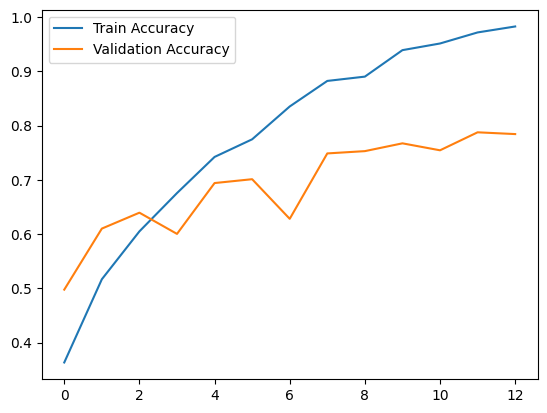

In [ ]:
#plot performance curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1

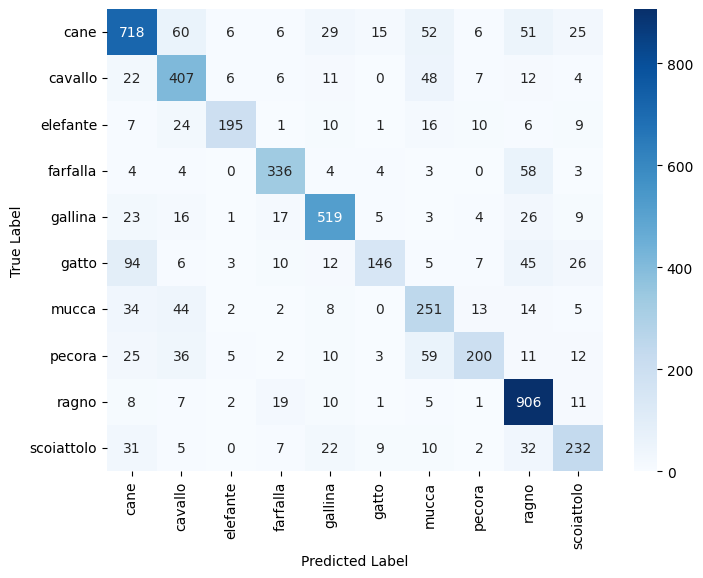

In [ ]:
# Confusion_matrix
y_true = []
y_pred = []

for images, labels in val_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Save the model

In [ ]:
model.save("cnn_model.h5")

In [ ]:
from tensorflow.keras.models import load_model
# load the CNN model
model = load_model("cnn_model.h5")

## VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load the pre-trained VGG16 model, excluding the top classification layers
VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent them from being trained
VGG16_model.trainable = False

# Create the model
VGG16_model = models.Sequential([

VGG16_model,
    layers.GlobalAveragePooling2D(),  # Global Average Pooling to reduce dimensions
    layers.Dense(256, activation='relu'),  # Custom dense layer
    layers.Dense(10, activation='softmax')  # Output layer
])

# Compile the model
VGG16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
VGG16_model.summary()

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Step 1: Create the ImageDataGenerator with normalization and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the images
    validation_split=0.2  # Split off 20% for validation
)

In [ ]:
# Step 2: Load the training data
train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/raw-img',
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse',
    subset='training'  # Training subset
)

Found 20947 images belonging to 10 classes.


In [ ]:
# Step 3: Load the validation data
val_data = train_datagen.flow_from_directory(  #use the same train_datagen with subset='validation'
    '/content/drive/MyDrive/archive/raw-img',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'  # Validation subset
)

Found 5232 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)


In [ ]:
# Train the model
VGG16_history = VGG16_model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    batch_size=128,# process 128 images at a time in each batch during training.
    callbacks=[early_stopping, reduce_lr] # stops training and reduces the learning rate if the validation loss stops improving for 3 epochs.
)


Epoch 1/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 161s 962ms/step - accuracy: 0.4492 - loss: 1.6905 - val_accuracy: 0.7414 - val_loss: 0.8714
Epoch 2/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 155s 942ms/step - accuracy: 0.7453 - loss: 0.8155 - val_accuracy: 0.7886 - val_loss: 0.6784
Epoch 3/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 158s 963ms/step - accuracy: 0.7833 - loss: 0.6649 - val_accuracy: 0.8010 - val_loss: 0.6143
Epoch 4/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 157s 959ms/step - accuracy: 0.8124 - loss: 0.5842 - val_accuracy: 0.8207 - val_loss: 0.5638
Epoch 5/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 154s 938ms/step - accuracy: 0.8233 - loss: 0.5408 - val_accuracy: 0.8242 - val_loss: 0.5367
Epoch 6/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 158s 965ms/step - accuracy: 0.8352 - loss: 0.5064 - val_accuracy: 0.8245 - val_loss: 0.5243
Epoch 7/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 197s 937ms/step - accuracy: 0.8419 - loss: 0.4829 - val_accuracy: 0.8343 - val_loss: 0.5047
Epoch 8/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 154s 937ms/step - accuracy: 0.8518 -

## Evaluate the model

In [ ]:
# evaluates the model's performance on the validation data:
loss, accuracy = VGG16_model.evaluate(val_data)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - accuracy: 0.8688 - loss: 0.4188
Validation Loss: 0.4198906719684601, Validation Accuracy: 0.8652523159980774


In [ ]:
import numpy as np

# These lists will store actual and predicted labels.
true_labels = []
predicted_labels = []

# Ensure val_data has a set number of batches
steps = len(val_data)  # Number of batches

for _ in range(steps):
    images, labels = next(iter(val_data))
    preds = VGG16_model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(labels)

# Converts lists into arrays for further analysis:
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

##Finding metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.8653
Precision: 0.8657
Recall: 0.8653
F1-score: 0.8651


##Visualizing performance plot

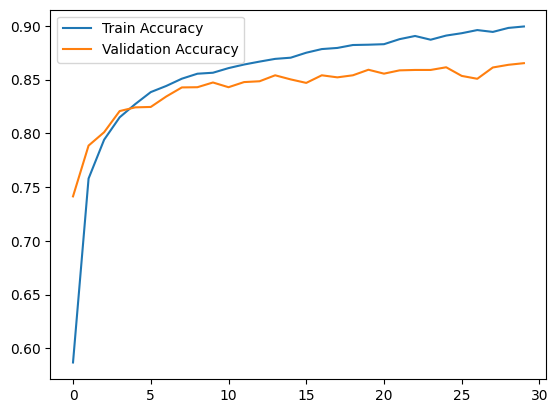

In [ ]:
#plot performance curves
plt.plot(VGG16_history.history['accuracy'], label='Train Accuracy')
plt.plot(VGG16_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

##Confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

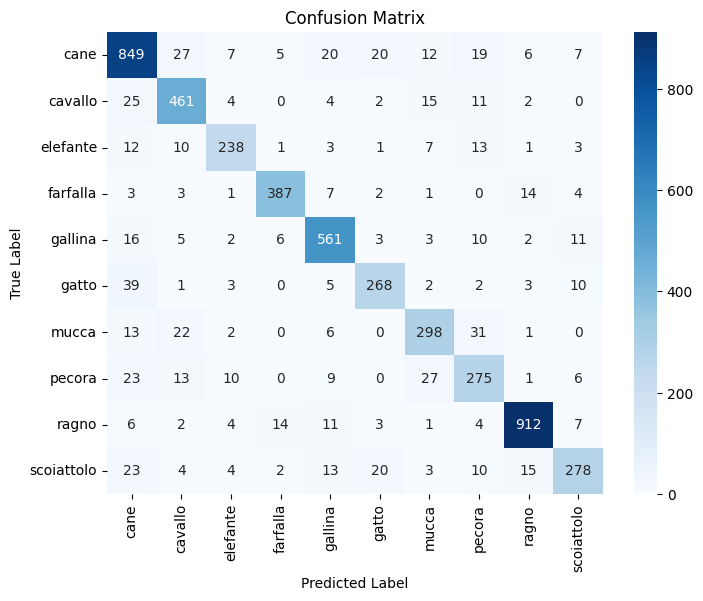

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

# Get the number of batches
steps = len(val_data)

# Iterate through all batches
for _ in range(steps):
    images, labels = next(val_data)
    preds = VGG16_model.predict(images)
    y_true.extend(labels)
    y_pred.extend(np.argmax(preds, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Save the model

In [ ]:
VGG16_model.save('VGG16 Model.h5')

In [ ]:
import pickle


model_filename = "vgg16_animal_classifier.pkl"

with open(model_filename, "wb") as file:
    pickle.dump(model, file)

print(f"✅ Model saved as {model_filename}")

✅ Model saved as vgg16_animal_classifier.pkl


##Comparison of models results

In [ ]:
from tensorflow.keras.models import load_model
# Load the models
cnn_model = load_model('/content/cnn_model.h5')
vgg_model = load_model('/content/VGG16 Model.h5')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data generators (with the correct directories and settings)
val_datagen = ImageDataGenerator(rescale=1./255)  # Normalize the images
val_data = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/raw-img',
    target_size=(224, 224),  # Match the input size of your models
    batch_size=32,
    class_mode='sparse'
)

Found 26179 images belonging to 10 classes.


In [ ]:
# Evaluate both models on validation data
cnn_eval = cnn_model.evaluate(val_data)
vgg_eval = vgg_model.evaluate(val_data)

print(f"CNN Model - Loss: {cnn_eval[0]:.4f}, Accuracy: {cnn_eval[1]:.4f}")
print(f"VGG16 Model - Loss: {vgg_eval[0]:.4f}, Accuracy: {vgg_eval[1]:.4f}")

# for histogram
cnn_loss = cnn_eval[0]
cnn_accuracy = cnn_eval[1]

vgg_loss = vgg_eval[0]
vgg_accuracy = vgg_eval[1]

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


819/819 ━━━━━━━━━━━━━━━━━━━━ 163s 197ms/step - accuracy: 0.0706 - loss: 2.3940
819/819 ━━━━━━━━━━━━━━━━━━━━ 147s 178ms/step - accuracy: 0.9017 - loss: 0.3045
CNN Model - Loss: 2.3975, Accuracy: 0.0691
VGG16 Model - Loss: 0.3063, Accuracy: 0.9026


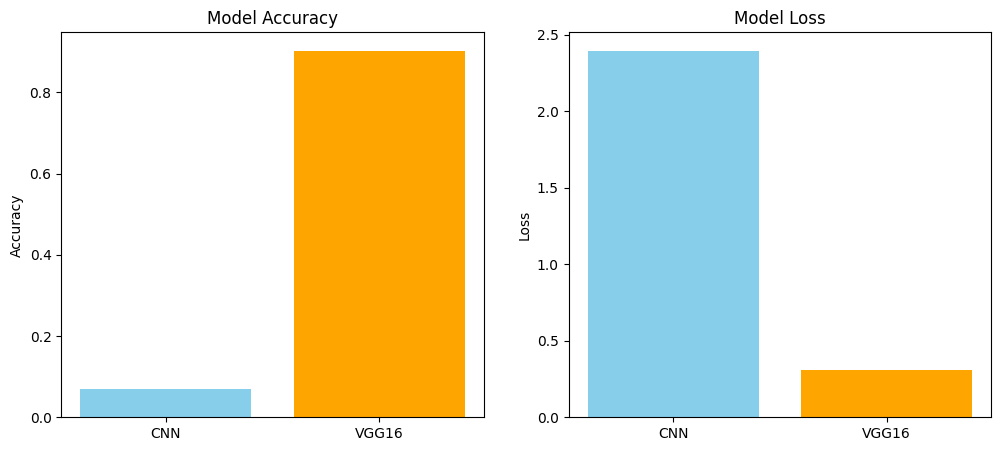

In [ ]:
import matplotlib.pyplot as plt

models = ['CNN', 'VGG16']
accuracy = [cnn_eval[1], vgg_eval[1]]
loss = [cnn_eval[0], vgg_eval[0]]

plt.figure(figsize=(12, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.bar(models, accuracy, color=['skyblue', 'orange'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')

# Loss comparison
plt.subplot(1, 2, 2)
plt.bar(models, loss, color=['skyblue', 'orange'])
plt.title('Model Loss')
plt.ylabel('Loss')

plt.show()


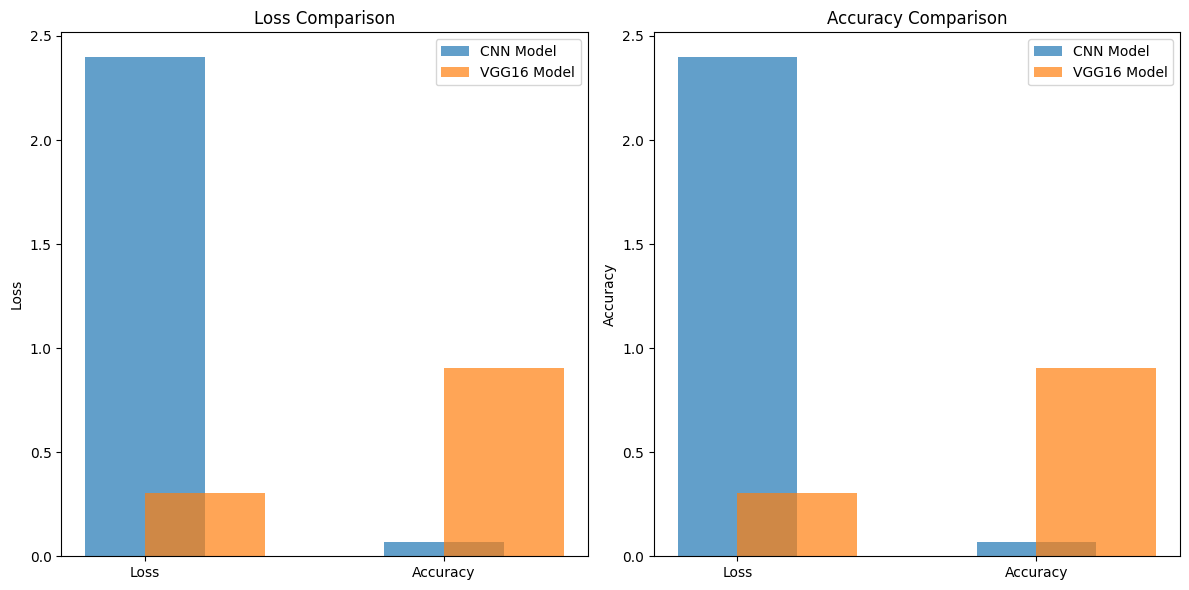

In [ ]:
import matplotlib.pyplot as plt

# Data for the histograms
metrics = ['Loss', 'Accuracy']
cnn_metrics = [cnn_loss, cnn_accuracy]
vgg_metrics = [vgg_loss, vgg_accuracy]

# Create histograms
plt.figure(figsize=(12, 6))

# Loss histogram
plt.subplot(1, 2, 1)
plt.bar(metrics, cnn_metrics, width=0.4, align='center', label='CNN Model', alpha=0.7)
plt.bar(metrics, vgg_metrics, width=0.4, align='edge', label='VGG16 Model', alpha=0.7)
plt.title('Loss Comparison')
plt.ylabel('Loss')
plt.legend()

# Accuracy histogram
plt.subplot(1, 2, 2)
plt.bar(metrics, cnn_metrics, width=0.4, align='center', label='CNN Model', alpha=0.7)
plt.bar(metrics, vgg_metrics, width=0.4, align='edge', label='VGG16 Model', alpha=0.7)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
